In [60]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.utils import resample
from tqdm import tqdm
import pickle

In [61]:
df = pd.read_csv("Datasets/training_data.csv")

In [62]:
df.shape

(14304, 18)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14304 entries, 0 to 14303
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               14304 non-null  int64 
 1   title                14304 non-null  object
 2   location             14024 non-null  object
 3   department           5029 non-null   object
 4   salary_range         2283 non-null   object
 5   company_profile      11632 non-null  object
 6   description          14303 non-null  object
 7   requirements         12172 non-null  object
 8   benefits             8501 non-null   object
 9   telecommuting        14304 non-null  int64 
 10  has_company_logo     14304 non-null  int64 
 11  has_questions        14304 non-null  int64 
 12  employment_type      11547 non-null  object
 13  required_experience  8629 non-null   object
 14  required_education   7805 non-null   object
 15  industry             10378 non-null  object
 16  func

In [64]:
new_df=df.drop(columns=['job_id', 'location','department','salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience','required_education', 'industry', 'function'], axis=1)

In [65]:
new_df.shape

(14304, 6)

In [66]:
new_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Contact Center Representatives,Tidewater Finance Co. was established in 1992 ...,"Tidewater Finance Company, located in Virginia...",The position requires the following qualificat...,Our company offers a competitive salary plus B...,0
1,Customer Service Associate,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,QualificationsMinimum of 1 year customer servi...,NaN,0
2,Automated Test Analyst,SilverStripe CMS &amp; Framework is an open so...,We are looking for a dedicated and passionate ...,NaN,NaN,0
3,Inside Sales Professional-Omaha,"ABC Supply Co., Inc. is the nation’s largest w...","As a Sales Representative, you will provide as...","As a Sales Representative, you must have the a...",Your benefits package as a Sales Representativ...,0
4,Content Marketing/SEO Manager,MeUndies is a lifestyle brand that is transfor...,MeUndies is a lifestyle brand that is transfor...,REQUIREMENTS/QUALIFICATIONS/PERSONAL ATTRIBUTE...,"WHY MEUNDIES?We're a fast-growing, VC-backed c...",0


In [67]:
new_df.isnull().sum()

title                 0
company_profile    2672
description           1
requirements       2132
benefits           5803
fraudulent            0
dtype: int64

In [68]:
new_df["company_profile"].fillna(new_df["company_profile"].mode()[0], inplace=True)
new_df["description"].fillna(new_df["description"].mode()[0], inplace=True)
new_df["requirements"].fillna(new_df["requirements"].mode()[0], inplace=True)
new_df["benefits"].fillna(new_df["benefits"].mode()[0], inplace=True)

C:\Users\perug\AppData\Local\Temp\ipykernel_33092\1198365526.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df["company_profile"].fillna(new_df["company_profile"].mode()[0], inplace=True)
C:\Users\perug\AppData\Local\Temp\ipykernel_33092\1198365526.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

In [69]:
new_df.isnull().sum()

title              0
company_profile    0
description        0
requirements       0
benefits           0
fraudulent         0
dtype: int64

In [70]:
new_df.groupby("fraudulent")["fraudulent"].count()

fraudulent
0    13611
1      693
Name: fraudulent, dtype: int64

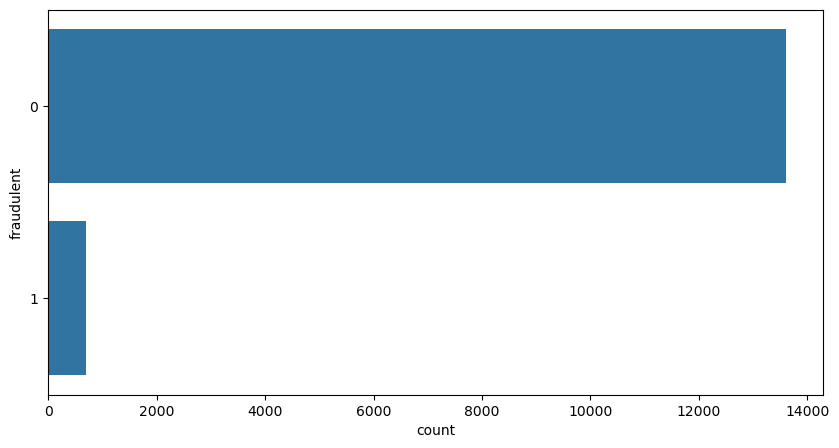

In [71]:
plt.figure(figsize = (10,5))
sns.countplot(y = 'fraudulent', data = new_df)
plt.show()

In [72]:
new_df["fraudulent"].value_counts(normalize=True)

fraudulent
0    0.951552
1    0.048448
Name: proportion, dtype: float64

In [73]:
new_df['merged_data'] = new_df["title"]+" "+new_df["company_profile"]+" "+new_df['description']+" "+new_df["requirements"]+new_df["benefits"]

In [74]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{"it'll", 'against', 'when', 'each', "that'll", 'any', 'mightn', 'do', "we'd", "she's", 'at', 'for', 'wouldn', 'does', 'their', "mustn't", 'in', 'above', 'yourselves', "doesn't", "hadn't", "they'd", 'so', 'because', 'if', "you've", "shouldn't", 'it', 'or', "haven't", 'some', 'where', 'a', 'll', "he'd", 've', 'aren', 'about', 'isn', "mightn't", 'off', 'to', 'ourselves', 'have', 'what', 'after', 'from', 'her', 'with', 'our', "she'd", "you're", 'other', 'now', 'all', "he'll", 'didn', 'should', 'up', "you'll", "they'll", 'which', "wasn't", 'won', 'wasn', 'until', 'during', 'your', "they've", 'before', 'over', 'has', 'himself', 'been', "it's", 'shouldn', 'was', 'than', 'same', 'she', 'nor', 'by', 'here', 'm', 'yours', "won't", 'can', 'such', 's', 'there', 'he', 'ain', "it'd", 'down', 'shan', 'themselves', 'were', 'doesn', 'very', 'once', 'couldn', 'both', 'own', 'needn', 'ours', 'who', 'into', "weren't", 'did', 'we', "you'd", 'haven', 'me', "hasn't", "i've", 'these', 'whom', 'and', 'you', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
port_stem = PorterStemmer()

In [76]:
def preprocess_text(text):
    return re.sub(r'[^a-zA-Z]', " ", text).lower()

In [77]:
def stemming(content):
        words = content.split()  # Tokenize words
        return " ".join([port_stem.stem(word) for word in words if word not in stop_words])

In [78]:
tqdm.pandas()

In [79]:
new_df['merged_data'] = new_df['merged_data'].progress_apply(lambda x:stemming(preprocess_text(x)))

100%|██████████| 14304/14304 [00:53<00:00, 269.54it/s]


In [80]:
X = new_df['merged_data'].values
Y = new_df['fraudulent'].values

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=4)

In [82]:
train_data = pd.DataFrame({'text': X_train, 'label': Y_train})

In [83]:
majority = train_data[train_data.label == 0]
minority = train_data[train_data.label == 1]

In [84]:
minority_upsampled = resample(minority, replace=True, n_samples=len(majority),random_state=32)

In [85]:
train_resampled = pd.concat([majority, minority_upsampled])

In [86]:
train_resampled = train_resampled.sample(frac=1, random_state=32).reset_index(drop=True)

In [87]:
x_train_resampled = train_resampled['text']
Y_train_resampled = train_resampled['label']

In [88]:
print(Y_train_resampled.value_counts())

label
1    10889
0    10889
Name: count, dtype: int64


In [89]:
print(x_train_resampled.shape)
Y_train_resampled.shape

(21778,)


(21778,)

In [90]:
imbalance_ratio = Y_train_resampled.value_counts()[0]/Y_train_resampled.value_counts()[1]
imbalance_ratio

1.0

In [91]:
vectorizer = TfidfVectorizer()
x_train_transformed = vectorizer.fit_transform(x_train_resampled)
x_test_transformed = vectorizer.transform(X_test)

In [98]:
model = XGBClassifier(use_label_encoder=False, eval_metric ='logloss', scale_pos_weight=1.0, random_state=32)
model.fit(x_train_transformed, Y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [99]:
X_train_prediction = model.predict(x_train_transformed)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train_resampled)
print("Training Accuracy = ", training_data_accuracy)

Training Accuracy =  1.0


In [100]:
X_test_prediction = model.predict(x_test_transformed)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print("Test accuracy = ", test_data_accuracy)

Test accuracy =  0.9839217056973086


In [101]:
y_pred = model.predict(x_test_transformed)
f1 = f1_score(Y_test, y_pred)
print("Validation F1 Score: ", f1)

Validation F1 Score:  0.8257575757575758


In [104]:
print("Classification report: ", classification_report(Y_test, y_pred))

Classification report:                precision    recall  f1-score   support

           0       0.99      0.99      0.99      2722
           1       0.87      0.78      0.83       139

    accuracy                           0.98      2861
   macro avg       0.93      0.89      0.91      2861
weighted avg       0.98      0.98      0.98      2861



In [105]:
with open("models/xgboost_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [106]:
with open("Models/xg_boostmodel.pkl", "wb") as f:
    pickle.dump(model, f)